# 

In [ ]:
import numpy as np
import pandas as pd
import gymnasium
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque
import random

# 데이터 로드 및 전처리
file_path = './data/data.csv'  # 데이터 파일 경로
data = pd.read_csv(file_path)  # CSV 파일 로드



# 학습 및 테스트 데이터 분리
train_years = [17, 18, 19, 20, 21, 22]  # 학습에 사용할 연도
test_year = 23  # 테스트에 사용할 연도

train_data = data[data['year'].isin(train_years)]  # 학습 데이터
test_data = data[data['year'] == test_year]  # 테스트 데이터

# 환경 클래스 정의
class PowerGridEnv(gymnasium.Env):
    def __init__(self, data, years):
        super(PowerGridEnv, self).__init__()
        self.data = data
        self.years = years
        self.current_year = None
        self.current_data = None
        self.current_step = 0
        self.previous_difference = None
        self.actions = np.linspace(-0.5, 0.5, 100)
        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    def reset(self, year=None, seed=None, options=None):
        super().reset(seed=seed)
        if year is None:
            self.current_year = np.random.choice(self.years)
        else:
            self.current_year = year
        self.current_data = self.data[self.data['year'] == self.current_year].reset_index(drop=True)
        self.current_step = 0
        self.previous_difference = None
        self.current_data['현재 발전량'] = self.current_data['수요량']
        state = self._get_state().astype(np.float32)
        return state, {}

    def _get_state(self):
        current_time = self.current_data.loc[self.current_step, '시간'] / 24.0
        current_production = self.current_data.loc[self.current_step, '현재 발전량'] / 1000.0
        last_hour_demand = self.current_data.loc[self.current_step - 1, '수요량'] / 1000.0 if self.current_step > 0 else 0
        current_year = self.current_data.loc[self.current_step, 'year'] / 22.0
        current_day_of_year = self.current_data.loc[self.current_step, 'day_of_year'] / 365.0
        state = np.array([current_time, current_production, last_hour_demand, current_year, current_day_of_year])
        return state

    def step(self, action):
        adjustment = self.actions[action]
        self.current_data.loc[self.current_step, '현재 발전량'] *= (1 + adjustment)
        current_production = self.current_data.loc[self.current_step, '현재 발전량']
        current_demand = self.current_data.loc[self.current_step, '수요량']
        difference = abs(current_demand - current_production)

        reward = -difference / current_demand

        if current_production < current_demand * 0.8:
            reward -= 5

        if difference < current_demand * 0.05:
            reward += 10

        if self.previous_difference is not None and difference < self.previous_difference:
            reward += 2

        self.previous_difference = difference
        self.current_step += 1
        done = self.current_step >= len(self.current_data)

        if done:
            next_state = np.zeros(self.observation_space.shape, dtype=np.float32)
        else:
            next_state = self._get_state().astype(np.float32)

        info = {
            "difference": difference,
            "current_demand": current_demand,
            "next_production": current_production
        }

        return next_state, reward, done, False, info


# 환경 인스턴스 생성
train_env = PowerGridEnv(train_data, train_years)
test_env = PowerGridEnv(test_data, [test_year])

# Actor-Critic 네트워크 정의
class ActorCritic(nn.Module):
    def __init__(self, action_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(5, 128)  # 첫 번째 전결합층 (입력: 5, 출력: 128)
        self.fc2 = nn.Linear(128, 128)  # 두 번째 전결합층 (입력: 128, 출력: 128)
        self.logits = nn.Linear(128, action_dim)  # 행동 확률을 출력하는 층 (입력: 128, 출력: 행동 공간 크기)
        self.value = nn.Linear(128, 1)  # 상태 가치를 출력하는 층 (입력: 128, 출력: 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # 첫 번째 전결합층과 ReLU 활성화 함수
        x = torch.relu(self.fc2(x))  # 두 번째 전결합층과 ReLU 활성화 함수
        logits = self.logits(x)  # 행동 확률
        value = self.value(x)  # 상태 가치
        return logits, value

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Actor-Critic 모델 인스턴스 생성
action_dim = len(train_env.actions)
actor_critic = ActorCritic(action_dim).to(device)  # 모델을 GPU로 이동
optimizer = optim.Adam(actor_critic.parameters(), lr=0.01)  # 학습률을 0.01로 설정

# 경험 재현 메모리
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

memory = ReplayMemory(10000)

# 훈련 함수 수정
def train_step(state, action, reward, next_state, done, gamma=0.99):
    memory.push((state, action, reward, next_state, done))

    if len(memory) < batch_size:
        return

    transitions = memory.sample(batch_size)
    batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

    batch_state = torch.tensor(batch_state, dtype=torch.float32).to(device)
    batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32).to(device)
    batch_action = torch.tensor(batch_action, dtype=torch.long).to(device)
    batch_reward = torch.tensor(batch_reward, dtype=torch.float32).to(device)
    batch_done = torch.tensor(batch_done, dtype=torch.float32).to(device)

    logits, value = actor_critic(batch_state)
    _, next_value = actor_critic(batch_next_state)
    action_prob = torch.softmax(logits, dim=-1)
    action_prob = action_prob.clamp(min=1e-10)  # 확률 값이 0보다 작은 경우를 방지
    selected_action_prob = action_prob.gather(1, batch_action.unsqueeze(-1)).squeeze(-1)
    td_target = batch_reward + (1 - batch_done) * gamma * next_value
    td_error = td_target - value

    actor_loss = -torch.log(selected_action_prob) * td_error.detach()
    critic_loss = td_error.pow(2)
    loss = actor_loss + critic_loss

    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()

batch_size = 64  # 배치 크기 설정

# 학습 루프 설정
num_epochs = 100  # 학습 에포크 수
episodes_per_epoch = 6  # 에포크당 에피소드 수를 6으로 설정
epoch_results = []  # 에포크 결과 저장

# tqdm을 사용하여 진행 상황 표시
for epoch in tqdm(range(num_epochs), desc="Epochs", leave=True):
    total_epoch_reward = 0  # 에포크당 총 보상 초기화
    all_differences = []  # 모든 차이 저장
    successful_episodes = 0  # 성공적인 에피소드 수 초기화

    for year in tqdm(train_years, desc="Episodes", leave=False):
        state, _ = train_env.reset(year=year)  # 특정 연도의 데이터로 환경 리셋
        done = False  # 에피소드 종료 여부 초기화
        episode_reward = 0  # 에피소드당 총 보상 초기화
        episode_differences = []  # 에피소드당 차이 저장

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            logits, value = actor_critic(state_tensor)
            action_prob = torch.softmax(logits, dim=-1).cpu().detach().numpy()
            action_prob = np.nan_to_num(action_prob, nan=1e-10, posinf=1e-10, neginf=1e-10)
            action = np.random.choice(len(action_prob[0]), p=action_prob[0])
            next_state, reward, done, _, info = train_env.step(action)

            train_step(state, action, reward, next_state, done, gamma=0.99)

            state = next_state
            episode_reward += reward
            episode_differences.append(info["difference"])

        total_epoch_reward += episode_reward
        all_differences.extend(episode_differences)
        
        # 현재 수요량 가져오기
        current_demand = train_data['수요량'][train_env.current_step-len(episode_differences):train_env.current_step].to_numpy()
        if all(difference <= 0.05 * demand for difference, demand in zip(episode_differences, current_demand)):
            successful_episodes += 1

    mse = mean_squared_error([0] * len(all_differences), all_differences)
    success_rate = successful_episodes / episodes_per_epoch
    epoch_results.append((epoch + 1, total_epoch_reward / episodes_per_epoch, mse, success_rate))
    print(f'Epoch {epoch + 1}/{num_epochs} - Total Reward: {total_epoch_reward / episodes_per_epoch}, MSE: {mse}, Success Rate = {success_rate * 100:.2f}%')

cuda


Epochs:   1%|▋                                                                      | 1/100 [04:05<6:45:07, 245.53s/it]

Epoch 1/100 - Total Reward: 96531.19528620185, MSE: 58.40576582627872, Success Rate = 83.33%



Epochs:   2%|█▍                                                                     | 2/100 [08:33<7:02:46, 258.84s/it]

Epoch 2/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:   3%|██▏                                                                    | 3/100 [13:00<7:04:03, 262.30s/it]

Epoch 3/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:   4%|██▊                                                                    | 4/100 [17:28<7:03:27, 264.66s/it]

Epoch 4/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:   5%|███▌                                                                   | 5/100 [22:02<7:04:20, 268.00s/it]

Epoch 5/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:   6%|████▎                                                                  | 6/100 [26:33<7:01:43, 269.19s/it]

Epoch 6/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:   7%|████▉                                                                  | 7/100 [31:02<6:56:46, 268.89s/it]

Epoch 7/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:   8%|█████▋                                                                 | 8/100 [35:31<6:52:25, 268.97s/it]

Epoch 8/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:   9%|██████▍                                                                | 9/100 [40:01<6:48:42, 269.48s/it]

Epoch 9/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  10%|███████                                                               | 10/100 [44:33<6:45:07, 270.08s/it]

Epoch 10/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  11%|███████▋                                                              | 11/100 [49:02<6:40:03, 269.70s/it]

Epoch 11/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  12%|████████▍                                                             | 12/100 [53:27<6:33:30, 268.31s/it]

Epoch 12/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  13%|█████████                                                             | 13/100 [57:51<6:27:24, 267.18s/it]

Epoch 13/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  14%|█████████▌                                                          | 14/100 [1:02:15<6:21:30, 266.16s/it]

Epoch 14/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  15%|██████████▏                                                         | 15/100 [1:06:39<6:15:56, 265.37s/it]

Epoch 15/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  16%|██████████▉                                                         | 16/100 [1:11:02<6:10:48, 264.86s/it]

Epoch 16/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  17%|███████████▌                                                        | 17/100 [1:15:26<6:05:58, 264.56s/it]

Epoch 17/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  18%|████████████▏                                                       | 18/100 [1:19:53<6:02:40, 265.38s/it]

Epoch 18/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  19%|████████████▉                                                       | 19/100 [1:24:21<5:59:01, 265.95s/it]

Epoch 19/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  20%|█████████████▌                                                      | 20/100 [1:28:50<5:55:48, 266.86s/it]

Epoch 20/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  21%|██████████████▎                                                     | 21/100 [1:33:17<5:51:37, 267.06s/it]

Epoch 21/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  22%|██████████████▉                                                     | 22/100 [1:37:43<5:46:44, 266.72s/it]

Epoch 22/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  23%|███████████████▋                                                    | 23/100 [1:42:14<5:43:55, 267.99s/it]

Epoch 23/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  24%|████████████████▎                                                   | 24/100 [1:46:45<5:40:24, 268.74s/it]

Epoch 24/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Epochs:  25%|█████████████████                                                   | 25/100 [1:51:17<5:37:06, 269.69s/it]

Epoch 25/100 - Total Reward: 96661.40404041069, MSE: 11.351602084367432, Success Rate = 100.00%



Episodes:  83%|█████████████████████████████████████████████████████████████▋            | 5/6 [03:44<00:44, 44.73s/it]

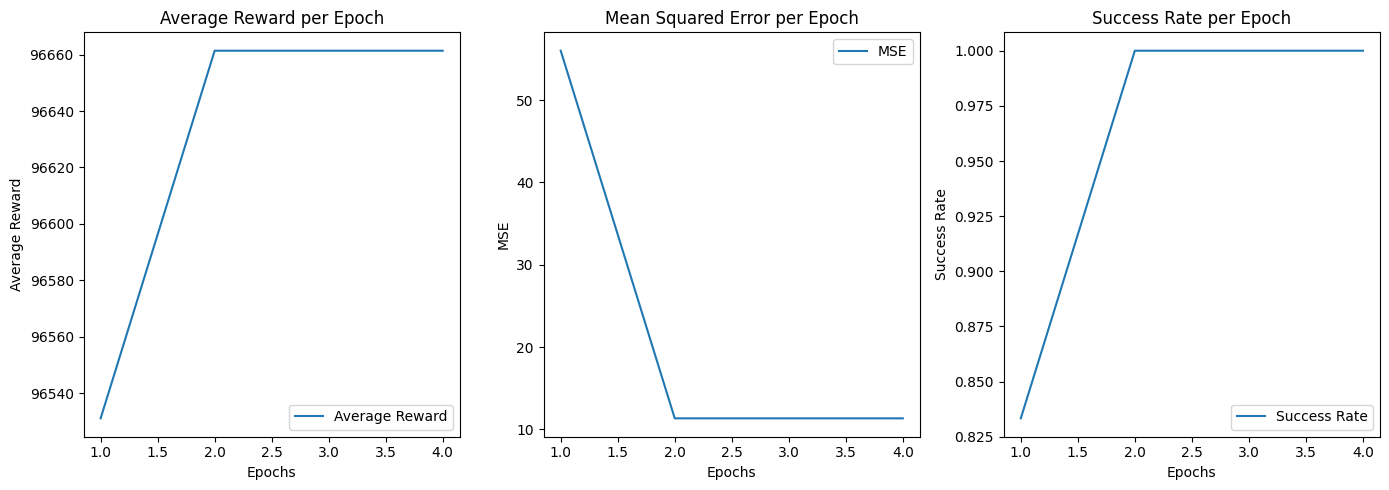

In [5]:
# 학습 결과 시각화
epochs, avg_rewards, mses, success_rates = zip(*epoch_results)

plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, avg_rewards, label='Average Reward')
plt.xlabel('Epochs')
plt.ylabel('Average Reward')
plt.title('Average Reward per Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, mses, label='MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Mean Squared Error per Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, success_rates, label='Success Rate')
plt.xlabel('Epochs')
plt.ylabel('Success Rate')
plt.title('Success Rate per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
def evaluate_model(env, model, device):
    state, _ = env.reset(year=test_year)
    done = False
    total_reward = 0
    all_differences = []
    all_demands = []
    all_productions = []

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        logits, value = model(state_tensor)
        action_prob = torch.softmax(logits, dim=-1).cpu().detach().numpy()
        action_prob = np.nan_to_num(action_prob, nan=1e-10, posinf=1e-10, neginf=1e-10)
        action = np.random.choice(len(action_prob[0]), p=action_prob[0])
        next_state, reward, done, _, info = env.step(action)

        state = next_state
        total_reward += reward
        all_differences.append(info["difference"])
        all_demands.append(info["current_demand"])
        all_productions.append(info["next_production"])

    mse = mean_squared_error([0] * len(all_differences), all_differences)
    return total_reward, mse, all_differences, all_demands, all_productions

# 테스트 데이터에 대한 평가 수행
test_total_reward, test_mse, test_differences, test_demands, test_productions = evaluate_model(test_env, actor_critic, device)
print(f'Test Total Reward: {test_total_reward}, Test MSE: {test_mse}')


Test Total Reward: 104404.12121213121, Test MSE: 13.71640735811297


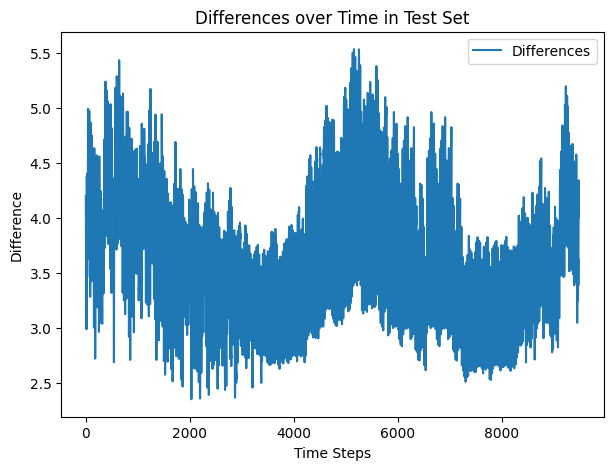

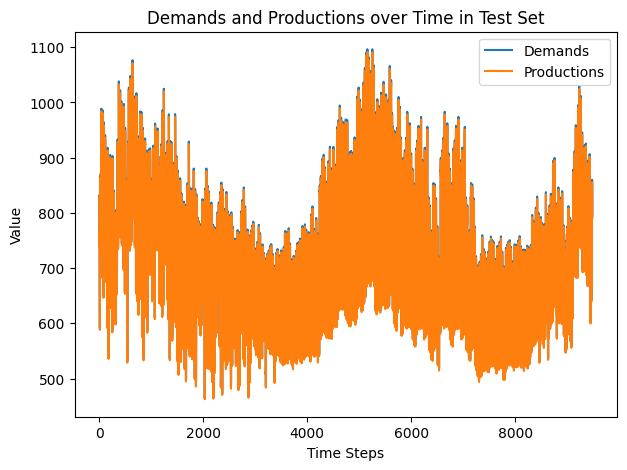

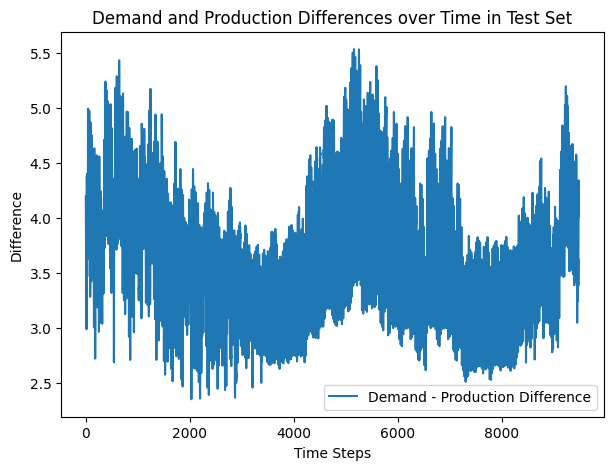

In [7]:
# 테스트 데이터의 차이 분포 시각화
plt.figure(figsize=(7, 5))
plt.plot(test_differences, label='Differences')
plt.xlabel('Time Steps')
plt.ylabel('Difference')
plt.title('Differences over Time in Test Set')
plt.legend()
plt.show()

# 수요량과 공급량 시각화
plt.figure(figsize=(7, 5))
plt.plot(test_demands, label='Demands')
plt.plot(test_productions, label='Productions')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Demands and Productions over Time in Test Set')
plt.legend()
plt.show()

# 수요량과 공급량의 차이 시각화
plt.figure(figsize=(7, 5))
plt.plot(np.array(test_demands) - np.array(test_productions), label='Demand - Production Difference')
plt.xlabel('Time Steps')
plt.ylabel('Difference')
plt.title('Demand and Production Differences over Time in Test Set')
plt.legend()
plt.show()